<a href="https://colab.research.google.com/github/Pranav03125/Intergrated_UFFT/blob/main/laundryWateWaterTreatment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

file_path = "/content/COMPLETE DATA.xlsx"

def load_and_check_sheet(sheet_name, expected_cols=None, header=0, skiprows=None):
    # Load sheet with specified header and skiprows
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=header, skiprows=skiprows)
    print(f"\nLoaded sheet '{sheet_name}' columns:")
    print(df.columns.tolist())
    if expected_cols:
        # Filter columns by intersection with expected_cols
        present_cols = [col for col in expected_cols if col in df.columns]
        if not present_cols:
            print(f"Warning: None of the expected columns found in sheet '{sheet_name}'")
            return pd.DataFrame()  # return empty df to prevent error
        else:
            print(f"Using columns from '{sheet_name}': {present_cols}")
            return df[present_cols].dropna(how='all')
    return df

# Define expected columns for sheets based on your Excel contents:

chito_rapid_cols = ['Rapid mixing rate (rpm)', 'Colour removal (%)', 'Turbidity removal (%)']
chito_slow_cols = ['Slow mixing rate (rpm)', 'Colour removal (%)', 'Turbidity removal (%)']
chito_time_cols = ['Rapid mixing time (min)', 'Slow mixing time (min)', 'Mixing time (min)',
                   'Colour removal (%)', 'Turbidity removal (%)']

poly_dose_expected_cols = ['Coagulant vol.', 'Colour removal (%)', 'Turbidity removal (%)',
                           'Nitrate conc.(ppm)', 'Iron conc.(ppm)', 'pH', 'DO(ppm)',
                           'Salinity(PPT)', 'TDS(ppt)']

poly_ph_expected_cols = ['Initial pH', 'Salinity (ppt)', 'TDS (ppt)', 'DO (ppm)',
                         'Colour removal (%)', 'Turbidity removal (%)']

# Load sheets safely with column checks
chito_rapid = load_and_check_sheet('Chito-rapid rate', expected_cols=chito_rapid_cols)
chito_slow = load_and_check_sheet('Chito-slow rate', expected_cols=chito_slow_cols)
chito_rapid_time = load_and_check_sheet('Chito-rapid time', expected_cols=chito_time_cols)
chito_slow_time = load_and_check_sheet('Chito-slow time', expected_cols=chito_time_cols)

# For poly-dose and poly-pH, inspect data and manually select rows to skip and use as header
# Based on the preview, poly-DOSE seems to have relevant data starting after row 3
poly_dose_raw = pd.read_excel(file_path, sheet_name='poly-DOSE')
print("\nRaw poly-DOSE sheet head:")
print(poly_dose_raw.head())
# Determine actual header row for poly-DOSE and then load with skiprows and header
# Assuming from preview the header is at row 4 (index 3) and data starts after that
poly_dose = pd.read_excel(file_path, sheet_name='poly-DOSE', header=3, skiprows=[4])
poly_dose.columns = poly_dose_expected_cols[:len(poly_dose.columns)] # Assign expected columns
poly_dose = poly_dose[poly_dose_expected_cols[:len(poly_dose.columns)]].dropna(how='all')
print(f"\nLoaded and cleaned poly-DOSE columns:")
print(poly_dose.columns.tolist())


# Based on the preview, poly-pH has header at row 1 (index 0)
# Load poly-pH and then clean up, remove non-numeric rows based on 'Initial pH'
poly_ph_raw = pd.read_excel(file_path, sheet_name='poly-pH')
print("\nRaw poly-pH sheet head:")
print(poly_ph_raw.head())

# Based on the raw data, the actual headers are in row 1 (index 0) and the data starts in row 2 (index 1)
# Also, the relevant columns are not in the order of poly_ph_expected_cols
# Manually select and rename columns
poly_ph = pd.read_excel(file_path, sheet_name='poly-pH', header=0, skiprows=[1])
poly_ph = poly_ph.rename(columns={'Raw': 'Initial pH', 'Unnamed: 4': 'Colour removal (%)', 'Unnamed: 7': 'Turbidity removal (%)', 'Unnamed: 2': 'Salinity (ppt)', 'Unnamed: 3': 'TDS (ppt)', 'Unnamed: 6': 'DO (ppm)'})
poly_ph = poly_ph[poly_ph_expected_cols].dropna(how='all')
# Clean up poly_ph, remove non-numeric rows based on 'Initial pH'
poly_ph = poly_ph[pd.to_numeric(poly_ph['Initial pH'], errors='coerce').notna()]
print(f"\nLoaded and cleaned poly-pH columns:")
print(poly_ph.columns.tolist())


# Fix column name conflicts
chito_rapid.rename(columns={'Rapid mixing rate (rpm)': 'Mixing rate (rpm)'}, inplace=True)
chito_slow.rename(columns={'Slow mixing rate (rpm)': 'Mixing rate (rpm)'}, inplace=True)
chito_rapid_time.rename(columns={'Rapid mixing time (min)': 'Mixing time (min)'}, inplace=True)
chito_slow_time.rename(columns={'Slow mixing time (min)': 'Mixing time (min)'}, inplace=True)

# Combine data, careful with common columns (Mixing rate/time/salinity etc)
df_list = [
    chito_rapid[['Mixing rate (rpm)', 'Colour removal (%)', 'Turbidity removal (%)']] if not chito_rapid.empty else pd.DataFrame(),
    chito_slow[['Mixing rate (rpm)', 'Colour removal (%)', 'Turbidity removal (%)']] if not chito_slow.empty else pd.DataFrame(),
    chito_rapid_time[['Mixing time (min)', 'Colour removal (%)', 'Turbidity removal (%)']] if not chito_rapid_time.empty else pd.DataFrame(),
    chito_slow_time[['Mixing time (min)', 'Colour removal (%)', 'Turbidity removal (%)']] if not chito_slow_time.empty else pd.DataFrame(),
    poly_dose if not poly_dose.empty else pd.DataFrame(),
    poly_ph if not poly_ph.empty else pd.DataFrame(),
]

combined_df = pd.concat(df_list, ignore_index=True, sort=False)

print(f"\nCombined data shape before fillna: {combined_df.shape}")

# Convert relevant columns to numeric, coercing errors to NaN
numeric_cols = ['Mixing rate (rpm)', 'Colour removal (%)', 'Turbidity removal (%)',
                'Mixing time (min)', 'Coagulant vol.', 'Nitrate conc.(ppm)',
                'Iron conc.(ppm)', 'pH', 'DO(ppm)', 'Salinity(PPT)', 'TDS(ppt)',
                'Salinity (ppt)', 'TDS (ppt)', 'Initial pH', 'DO (ppm)']

for col in numeric_cols:
    if col in combined_df.columns:
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Fill missing numerical data
combined_df.fillna(combined_df.median(numeric_only=True), inplace=True)

# Ensure only numeric columns are passed to augment_data
cols_to_augment = combined_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns selected for augmentation:\n{cols_to_augment}")


def augment_data(df, cols, noise_level=0.03, n_copies=10):
    augmented = [df]
    for _ in range(n_copies):
        df_aug = df.copy()
        for col in cols:
            # Ensure the column is numeric before calculating range and adding noise
            if pd.api.types.is_numeric_dtype(df_aug[col]):
                col_range = df_aug[col].max() - df_aug[col].min()
                noise = np.random.normal(0, noise_level * col_range, size=len(df_aug))
                df_aug[col] = df_aug[col] + noise

        # Clip known columns to realistic physical ranges (only apply to existing and numeric columns)
        clip_ranges = {
            'Mixing rate (rpm)': (0, 350),
            'Mixing time (min)': (0, 60),
            'Coagulant vol.': (0, 500),
            'Colour removal (%)': (0, 100),
            'Turbidity removal (%)': (0, 100),
            'pH': (4, 10),
            'Initial pH': (4, 10), # Add clipping for 'Initial pH' as well
        }
        for col, (lower, upper) in clip_ranges.items():
            if col in df_aug.columns and pd.api.types.is_numeric_dtype(df_aug[col]):
                 df_aug[col] = df_aug[col].clip(lower=lower, upper=upper)

        # Clip columns that should be non-negative (only apply to existing and numeric columns)
        non_negative_cols = ['Nitrate conc.(ppm)', 'Iron conc.(ppm)', 'DO(ppm)', 'Salinity(PPT)', 'TDS(ppt)', 'Salinity (ppt)', 'TDS (ppt)', 'DO (ppm)'] # Add 'DO (ppm)'
        for col in non_negative_cols:
             if col in df_aug.columns and pd.api.types.is_numeric_dtype(df_aug[col]):
                df_aug[col] = df_aug[col].clip(lower=0)

        augmented.append(df_aug)

    return pd.concat(augmented, ignore_index=True)

augmented_df = augment_data(combined_df, cols_to_augment, noise_level=0.03, n_copies=10)

print(f"Original combined data shape: {combined_df.shape}")
print(f"Augmented data shape: {augmented_df.shape}")

# Save to CSV for ML training
augmented_df.to_csv("augmented_laundry_dataset_final.csv", index=False)
print("Augmented dataset saved as 'augmented_laundry_dataset_final.csv'")


Loaded sheet 'Chito-rapid rate' columns:
['Rapid mixing rate (rpm)', 'Colour removal (%)', 'Turbidity removal (%)']
Using columns from 'Chito-rapid rate': ['Rapid mixing rate (rpm)', 'Colour removal (%)', 'Turbidity removal (%)']

Loaded sheet 'Chito-slow rate' columns:
['Slow mixing rate (rpm)', 'Colour removal (%)', 'Turbidity removal (%)']
Using columns from 'Chito-slow rate': ['Slow mixing rate (rpm)', 'Colour removal (%)', 'Turbidity removal (%)']

Loaded sheet 'Chito-rapid time' columns:
['Rapid mixing time (min)', 'Colour removal (%)', 'Turbidity removal (%)']
Using columns from 'Chito-rapid time': ['Rapid mixing time (min)', 'Colour removal (%)', 'Turbidity removal (%)']

Loaded sheet 'Chito-slow time' columns:
['Slow mixing time (min)', 'Colour removal (%)', 'Turbidity removal (%)']
Using columns from 'Chito-slow time': ['Slow mixing time (min)', 'Colour removal (%)', 'Turbidity removal (%)']

Raw poly-DOSE sheet head:
             Coagulant used: AMEZTREAT 102 POLYAMINE     

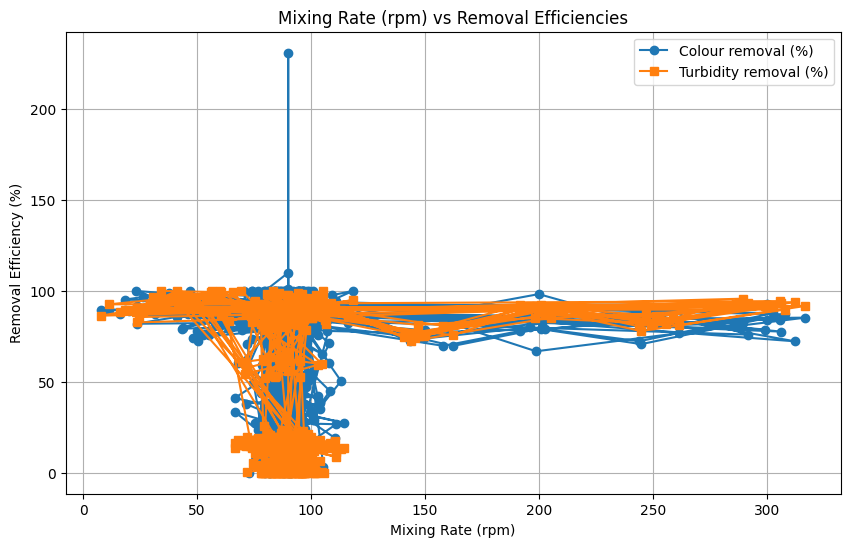

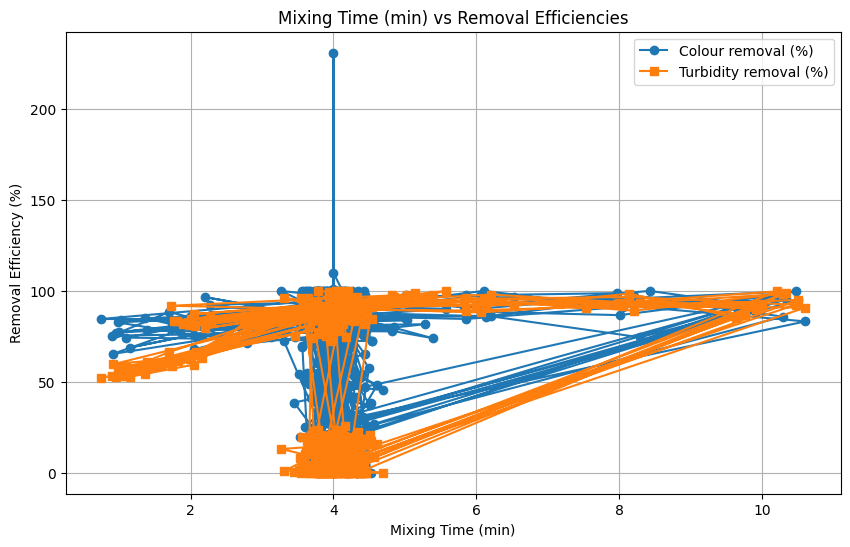

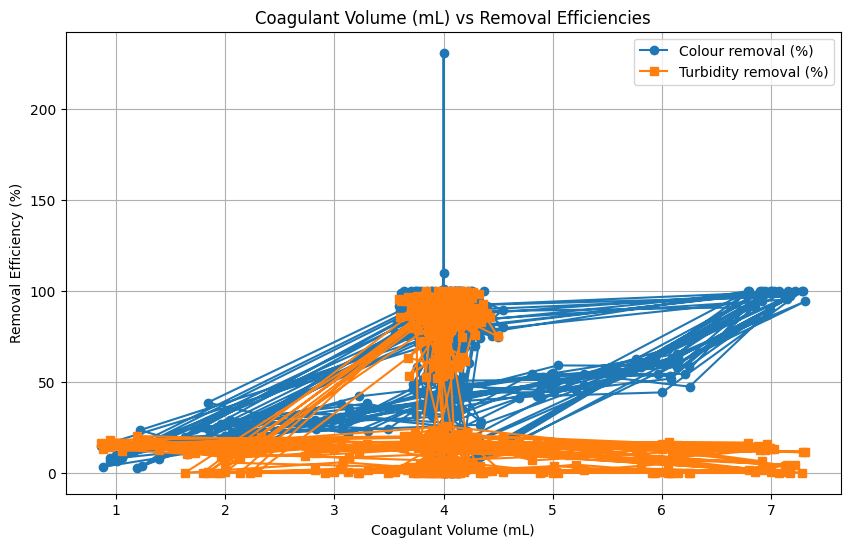

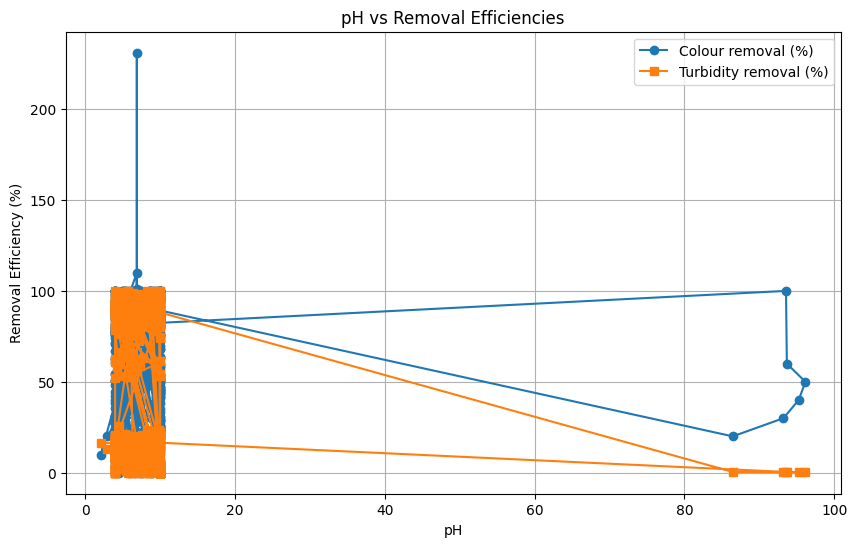

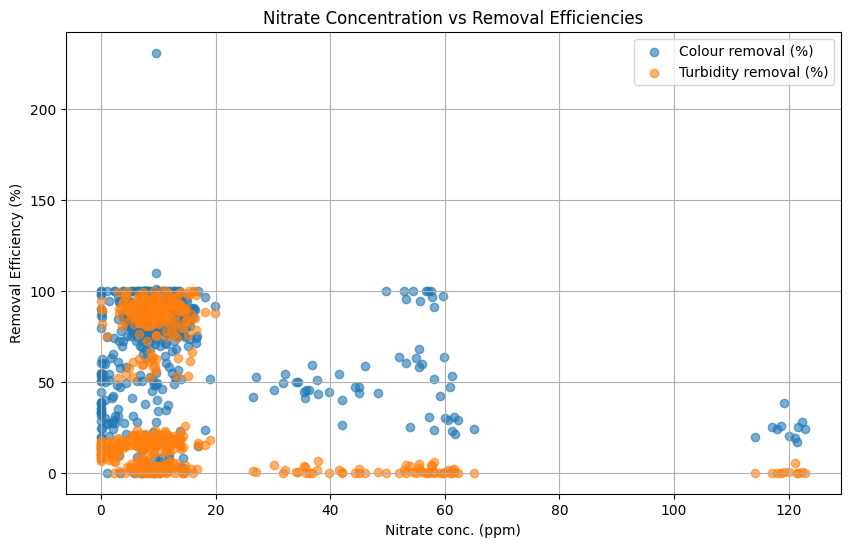

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load augmented dataset
df = pd.read_csv("augmented_laundry_dataset_final.csv")

# Define plotting functions for clarity

def plot_removal_vs_mixing_rate(df):
    if 'Mixing rate (rpm)' in df and 'Colour removal (%)' in df and 'Turbidity removal (%)' in df:
        plt.figure(figsize=(10,6))
        plt.plot(df['Mixing rate (rpm)'], df['Colour removal (%)'], 'o-', label='Colour removal (%)')
        plt.plot(df['Mixing rate (rpm)'], df['Turbidity removal (%)'], 's-', label='Turbidity removal (%)')
        plt.title('Mixing Rate (rpm) vs Removal Efficiencies')
        plt.xlabel('Mixing Rate (rpm)')
        plt.ylabel('Removal Efficiency (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_removal_vs_mixing_time(df):
    if 'Mixing time (min)' in df and 'Colour removal (%)' in df and 'Turbidity removal (%)' in df:
        plt.figure(figsize=(10,6))
        plt.plot(df['Mixing time (min)'], df['Colour removal (%)'], 'o-', label='Colour removal (%)')
        plt.plot(df['Mixing time (min)'], df['Turbidity removal (%)'], 's-', label='Turbidity removal (%)')
        plt.title('Mixing Time (min) vs Removal Efficiencies')
        plt.xlabel('Mixing Time (min)')
        plt.ylabel('Removal Efficiency (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_removal_vs_coagulant_vol(df):
    if 'Coagulant vol.' in df and 'Colour removal (%)' in df and 'Turbidity removal (%)' in df:
        plt.figure(figsize=(10,6))
        plt.plot(df['Coagulant vol.'], df['Colour removal (%)'], 'o-', label='Colour removal (%)')
        plt.plot(df['Coagulant vol.'], df['Turbidity removal (%)'], 's-', label='Turbidity removal (%)')
        plt.title('Coagulant Volume (mL) vs Removal Efficiencies')
        plt.xlabel('Coagulant Volume (mL)')
        plt.ylabel('Removal Efficiency (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_removal_vs_pH(df):
    # Using 'pH' if present, else 'Initial pH'
    ph_col = None
    if 'pH' in df:
        ph_col = 'pH'
    elif 'Initial pH' in df:
        ph_col = 'Initial pH'

    if ph_col and 'Colour removal (%)' in df and 'Turbidity removal (%)' in df:
        plt.figure(figsize=(10,6))
        plt.plot(df[ph_col], df['Colour removal (%)'], 'o-', label='Colour removal (%)')
        plt.plot(df[ph_col], df['Turbidity removal (%)'], 's-', label='Turbidity removal (%)')
        plt.title(f'{ph_col} vs Removal Efficiencies')
        plt.xlabel(ph_col)
        plt.ylabel('Removal Efficiency (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_nitrate_vs_removal(df):
    if 'Nitrate conc.(ppm)' in df and 'Colour removal (%)' in df and 'Turbidity removal (%)' in df:
        plt.figure(figsize=(10,6))
        plt.scatter(df['Nitrate conc.(ppm)'], df['Colour removal (%)'], alpha=0.6, label='Colour removal (%)')
        plt.scatter(df['Nitrate conc.(ppm)'], df['Turbidity removal (%)'], alpha=0.6, label='Turbidity removal (%)')
        plt.title('Nitrate Concentration vs Removal Efficiencies')
        plt.xlabel('Nitrate conc. (ppm)')
        plt.ylabel('Removal Efficiency (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

# Call the plotting functions

plot_removal_vs_mixing_rate(df)
plot_removal_vs_mixing_time(df)
plot_removal_vs_coagulant_vol(df)
plot_removal_vs_pH(df)
plot_nitrate_vs_removal(df)


In [3]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = '/content/augmented_laundry_dataset_cleaned.csv'
df = pd.read_csv(file_path)

# 1. Overview of columns and initial data types
print("Initial Columns:", df.columns)
print("Initial Data Types:", df.dtypes)

# 2. Remove duplicate rows
df = df.drop_duplicates()

# 3. Check for missing values and handle them
print("Missing values per column before cleaning:\n", df.isnull().sum())

# Option 1: Drop rows with any missing values (if dataset is large enough)
# df = df.dropna()

# Option 2: Fill numerical missing values with the column mean (recommended for numerical data)
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].mean(), inplace=True)

# Option 3: Fill categorical missing values with the mode
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode(), inplace=True)

print("Missing values per column after cleaning:\n", df.isnull().sum())

# 4. Convert columns to appropriate data types if necessary
# Example: Convert 'Mixing rate (rpm)' to float
numeric_columns = [
    'Mixing rate (rpm)', 'Colour removal (%)', 'Turbidity removal (%)',
    'Mixing time (min)', 'Coagulant vol.', 'Nitrate conc.(ppm)',
    'Iron conc.(ppm)', 'pH', 'DO(ppm)', 'Salinity(PPT)',
    'Initial pH', 'Salinity (ppt)', 'TDS (ppt)', 'DO (ppm)'
]
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 5. Handle any remaining non-numeric entries in numeric columns
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.name in numeric_columns else x)

# 6. Optionally, normalize/standardize columns for future analysis
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# 7. Save cleaned data to new CSV
output_path = 'augmented_laundry_dataset_cleaned.csv'
df.to_csv(output_path, index=False)
print(f"Cleaned data saved to {output_path}")


Initial Columns: Index(['Mixing rate (rpm)', 'Colour removal (%)', 'Turbidity removal (%)',
       'Mixing time (min)', 'Coagulant vol.', 'Nitrate conc.(ppm)',
       'Iron conc.(ppm)', 'pH', 'DO(ppm)', 'Salinity(PPT)', 'Initial pH',
       'Salinity (ppt)', 'TDS (ppt)', 'DO (ppm)'],
      dtype='object')
Initial Data Types: Mixing rate (rpm)        float64
Colour removal (%)       float64
Turbidity removal (%)    float64
Mixing time (min)        float64
Coagulant vol.           float64
Nitrate conc.(ppm)       float64
Iron conc.(ppm)          float64
pH                       float64
DO(ppm)                  float64
Salinity(PPT)            float64
Initial pH               float64
Salinity (ppt)           float64
TDS (ppt)                float64
DO (ppm)                 float64
dtype: object
Missing values per column before cleaning:
 Mixing rate (rpm)        0
Colour removal (%)       0
Turbidity removal (%)    0
Mixing time (min)        0
Coagulant vol.           0
Nitrate conc.(ppm)

/tmp/ipython-input-2383875465.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


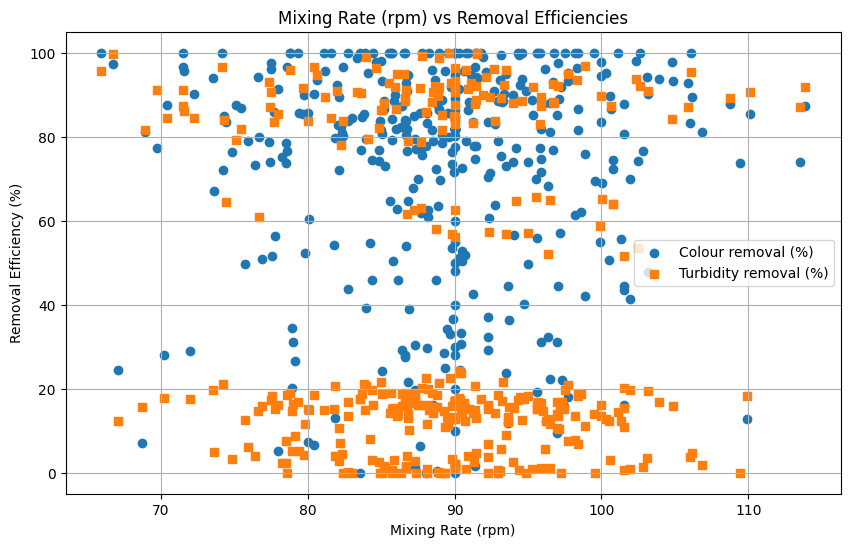

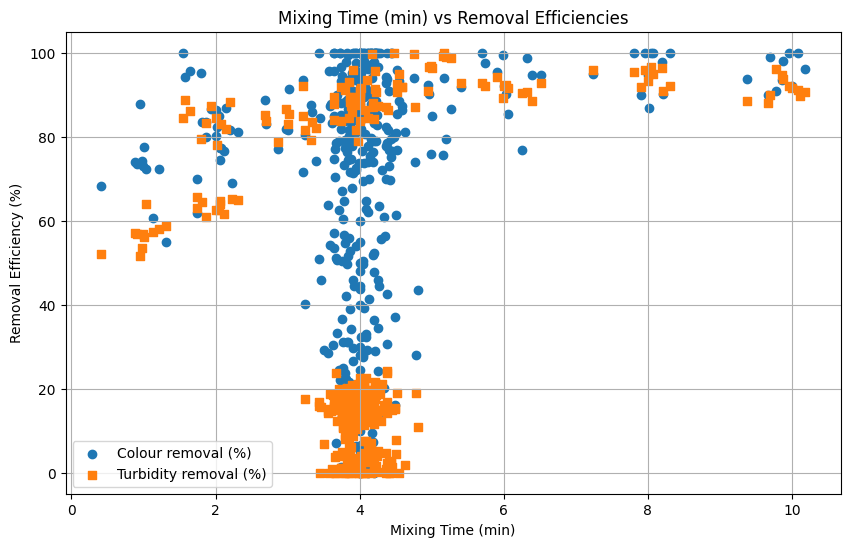

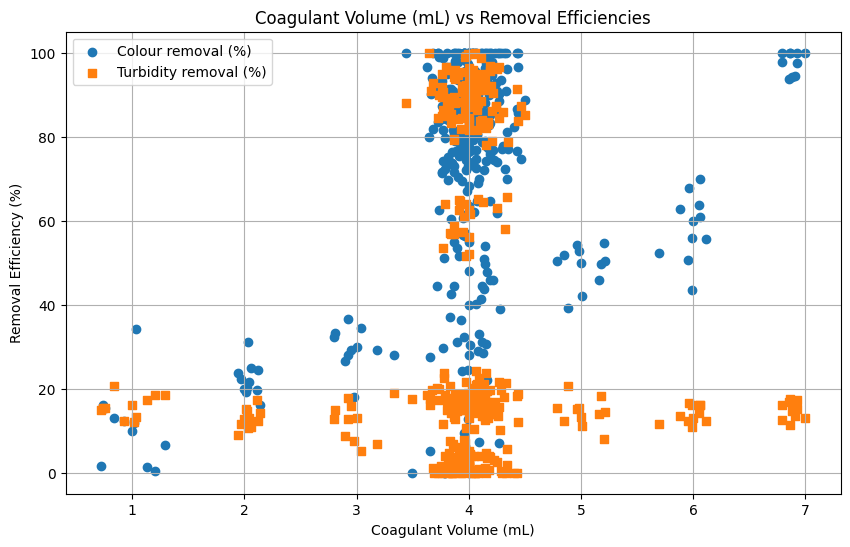

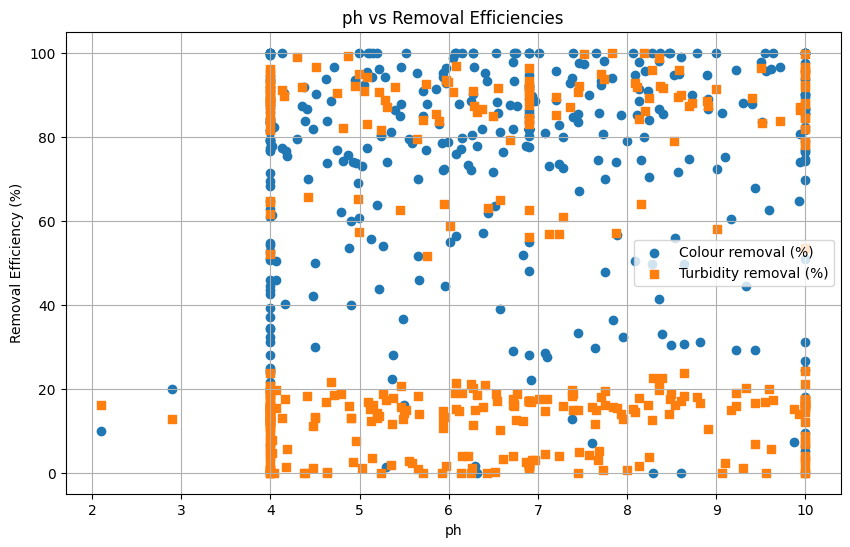

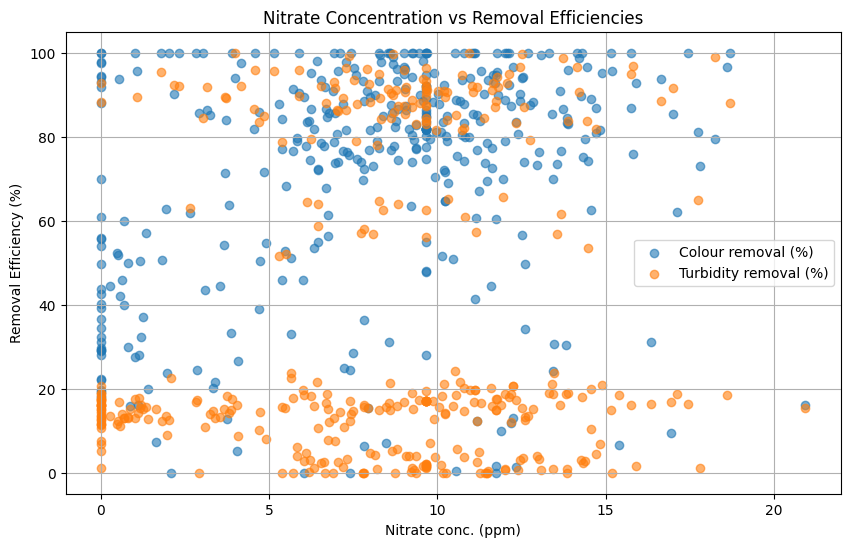

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned laundry dataset Excel file
df = pd.read_csv("/content/cleaned_laundry_dataset.csv")

# Define plotting functions (adjusted to column names in Excel)

def plot_removal_vs_mixing_rate(df):
    if 'mixing_rate_rpm' in df.columns and 'colour_removal_' in df.columns and 'turbidity_removal_' in df.columns:
        plt.figure(figsize=(10,6))
        plt.scatter(df['mixing_rate_rpm'], df['colour_removal_'], label='Colour removal (%)', marker='o')
        plt.scatter(df['mixing_rate_rpm'], df['turbidity_removal_'], label='Turbidity removal (%)', marker='s')
        plt.title('Mixing Rate (rpm) vs Removal Efficiencies')
        plt.xlabel('Mixing Rate (rpm)')
        plt.ylabel('Removal Efficiency (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_removal_vs_mixing_time(df):
    if 'mixing_time_min' in df.columns and 'colour_removal_' in df.columns and 'turbidity_removal_' in df.columns:
        plt.figure(figsize=(10,6))
        plt.scatter(df['mixing_time_min'], df['colour_removal_'], label='Colour removal (%)', marker='o')
        plt.scatter(df['mixing_time_min'], df['turbidity_removal_'], label='Turbidity removal (%)', marker='s')
        plt.title('Mixing Time (min) vs Removal Efficiencies')
        plt.xlabel('Mixing Time (min)')
        plt.ylabel('Removal Efficiency (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_removal_vs_coagulant_vol(df):
    if 'coagulant_vol' in df.columns and 'colour_removal_' in df.columns and 'turbidity_removal_' in df.columns:
        plt.figure(figsize=(10,6))
        plt.scatter(df['coagulant_vol'], df['colour_removal_'], label='Colour removal (%)', marker='o')
        plt.scatter(df['coagulant_vol'], df['turbidity_removal_'], label='Turbidity removal (%)', marker='s')
        plt.title('Coagulant Volume (mL) vs Removal Efficiencies')
        plt.xlabel('Coagulant Volume (mL)')
        plt.ylabel('Removal Efficiency (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_removal_vs_pH(df):
    ph_col = None
    if 'ph' in df.columns:
        ph_col = 'ph'
    elif 'initial_ph' in df.columns:
        ph_col = 'initial_ph'

    if ph_col and 'colour_removal_' in df.columns and 'turbidity_removal_' in df.columns:
        plt.figure(figsize=(10,6))
        plt.scatter(df[ph_col], df['colour_removal_'], label='Colour removal (%)', marker='o')
        plt.scatter(df[ph_col], df['turbidity_removal_'], label='Turbidity removal (%)', marker='s')
        plt.title(f'{ph_col} vs Removal Efficiencies')
        plt.xlabel(ph_col)
        plt.ylabel('Removal Efficiency (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

def plot_nitrate_vs_removal(df):
    if 'nitrate_concppm' in df.columns and 'colour_removal_' in df.columns and 'turbidity_removal_' in df.columns:
        plt.figure(figsize=(10,6))
        plt.scatter(df['nitrate_concppm'], df['colour_removal_'], alpha=0.6, label='Colour removal (%)')
        plt.scatter(df['nitrate_concppm'], df['turbidity_removal_'], alpha=0.6, label='Turbidity removal (%)')
        plt.title('Nitrate Concentration vs Removal Efficiencies')
        plt.xlabel('Nitrate conc. (ppm)')
        plt.ylabel('Removal Efficiency (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

# Call the plotting functions

plot_removal_vs_mixing_rate(df)
plot_removal_vs_mixing_time(df)
plot_removal_vs_coagulant_vol(df)
plot_removal_vs_pH(df)
plot_nitrate_vs_removal(df)



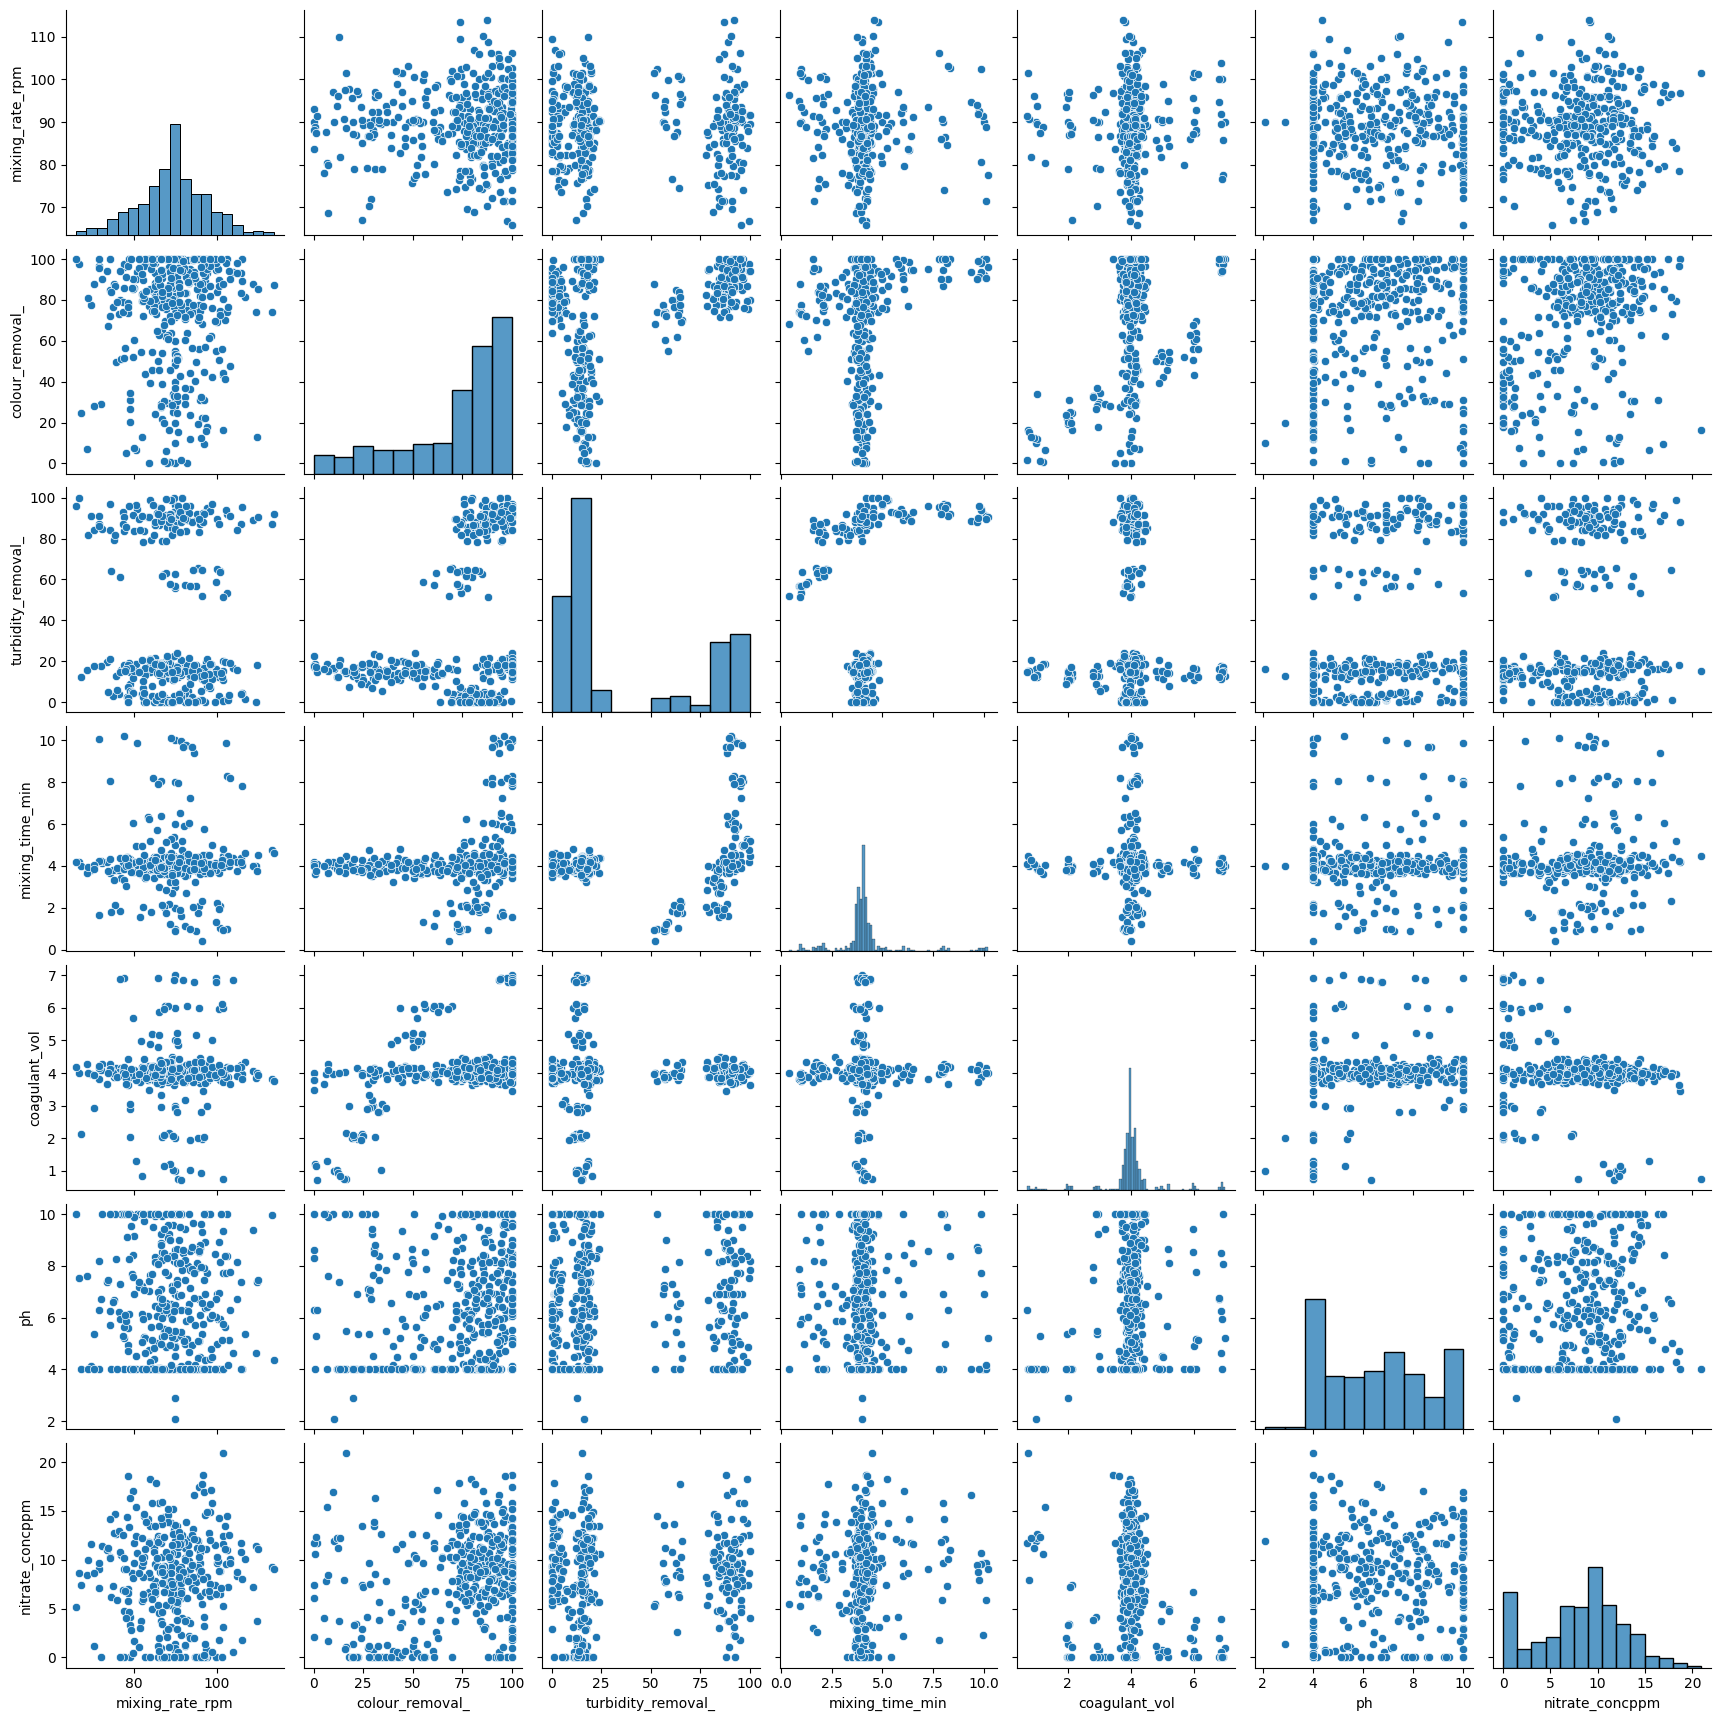

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned dataset (your CSV path)
df = pd.read_csv('cleaned_laundry_dataset.csv')

# Select relevant columns
columns = ['mixing_rate_rpm', 'colour_removal_', 'turbidity_removal_', 'mixing_time_min', 'coagulant_vol', 'ph', 'nitrate_concppm']
df_subset = df[columns].dropna()

# Create pairplot
sns.pairplot(df_subset)
plt.show()

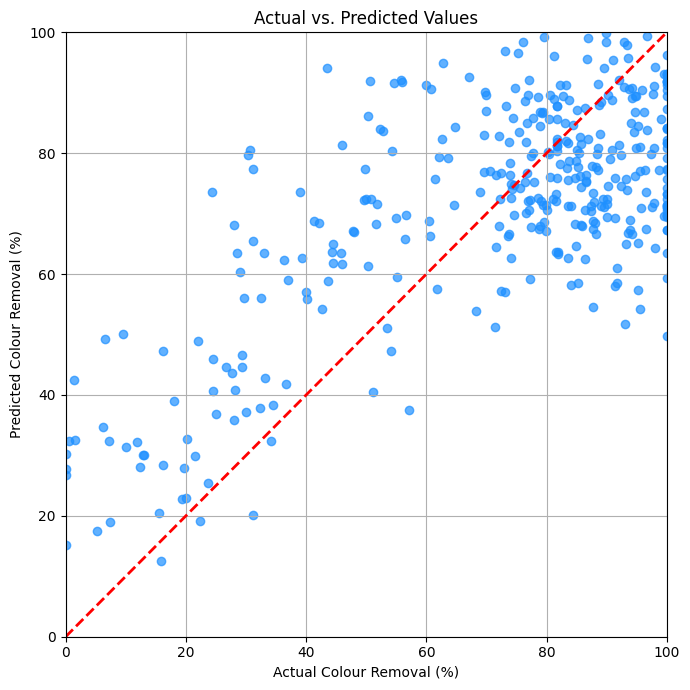

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv('/content/cleaned_laundry_dataset.csv')

# Replace 'predicted_colour_removal' with your actual model's predictions.
# For demonstration, let's simulate predictions using a simple regression:
# You need to update 'predicted_colour_removal' with real predicted data in practice.
from sklearn.linear_model import LinearRegression

# Features and target
X = df[['mixing_rate_rpm', 'mixing_time_min', 'coagulant_vol', 'ph', 'doppm', 'salinityppt',
        'initial_ph', 'tds_ppt', 'nitrate_concppm', 'iron_concppm']]
y = df['colour_removal_']

# Fit a linear regression model (replace with your own model if needed)
model = LinearRegression()
model.fit(X, y)
df['predicted_colour_removal'] = model.predict(X)

# Plot Actual vs Predicted
plt.figure(figsize=(7,7))
plt.scatter(df['colour_removal_'], df['predicted_colour_removal'], color='dodgerblue', alpha=0.7)
plt.plot([0, 100], [0, 100], 'r--', lw=2)  # 45-degree reference line
plt.xlabel("Actual Colour Removal (%)")
plt.ylabel("Predicted Colour Removal (%)")
plt.title("Actual vs. Predicted Values")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# --- Step 1: Upload your Excel file ---
from google.colab import files
import pandas as pd, numpy as np, re, json, warnings, os
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
RND = 42
np.random.seed(RND)

print("/content/COMPLETE DATA (1).xlsx")
uploaded = files.upload()

# Take the first uploaded file
EXCEL_PATH = list(uploaded.keys())[0]
OUT_DIR = "/content"   # Colab workspace

# --- Augmentation Parameters ---
N_GAUSS = 300
N_MIXUP = 300
N_MODEL = 400
NOISE_LEVEL = 0.03
MIXUP_ALPHA = 0.2

# Explicit column map (optional, fill later if needed)
EXPLICIT_COLUMN_MAP = {}

# --- Helper Functions ---
def clean_cols(cols):
    return [re.sub(r'[^0-9a-zA-Z_]', '_', str(c).strip().lower()) for c in cols]

def coerce_numeric_column(s):
    if s.dtype == 'O':
        cleaned = s.astype(str).str.replace('[^0-9eE\+\-\.]', ' ', regex=True).str.strip()
        cleaned = cleaned.str.replace(r'\s+', ' ', regex=True)
        return pd.to_numeric(cleaned, errors='coerce')
    else:
        return pd.to_numeric(s, errors='coerce')

def find_cols_by_keywords(colnames, keywords):
    pat = re.compile('|'.join(keywords), flags=re.I)
    return [c for c in colnames if pat.search(c)]

def clamp_removal_pct(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].clip(lower=0, upper=100)

# --- Augmentation Methods ---
def augment_gaussian_noise(df, feature_cols, target_cols, n_new=N_GAUSS, noise_level=NOISE_LEVEL):
    numeric = df[feature_cols + target_cols].copy().reset_index(drop=True)
    stds = numeric.std()
    out = []
    for _ in range(n_new):
        idx = np.random.randint(0, len(numeric))
        base = numeric.loc[idx].copy()
        noise = np.random.normal(loc=0.0, scale=stds * noise_level)
        new = base + noise
        out.append(new)
    df_new = pd.DataFrame(out, columns=numeric.columns)
    for c in df_new.columns:
        orig_min = numeric[c].min()
        if pd.notna(orig_min) and orig_min >= 0:
            df_new[c] = df_new[c].clip(lower=0)
    return df_new

def augment_mixup(df, feature_cols, target_cols, n_new=N_MIXUP, alpha=MIXUP_ALPHA):
    numeric = df[feature_cols + target_cols].copy().reset_index(drop=True)
    out = []
    for _ in range(n_new):
        a, b = np.random.choice(numeric.index, size=2, replace=False)
        lam = np.random.beta(alpha, alpha)
        new = lam * numeric.loc[a] + (1 - lam) * numeric.loc[b]
        out.append(new)
    df_new = pd.DataFrame(out, columns=numeric.columns)
    for c in df_new.columns:
        orig_min = numeric[c].min()
        if pd.notna(orig_min) and orig_min >= 0:
            df_new[c] = df_new[c].clip(lower=0)
    return df_new

def augment_model_based(df, feature_cols, target_cols, n_new=N_MODEL):
    X = df[feature_cols].values
    y = df[target_cols].values
    if len(X) < 5:
        return augment_gaussian_noise(df, feature_cols, target_cols, n_new=n_new, noise_level=NOISE_LEVEL)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=RND)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=RND, max_depth=10))
    model.fit(X_train_s, y_train)
    sampled_idx = np.random.choice(np.arange(len(X)), size=n_new, replace=True)
    X_new = X[sampled_idx].copy()
    fstd = np.std(X, axis=0)
    jitter = np.random.normal(scale=fstd * 0.01, size=X_new.shape)
    X_new = X_new + jitter
    X_new_s = scaler.transform(X_new)
    y_pred = model.predict(X_new_s)
    y_pred = y_pred + np.random.normal(scale=np.std(y, axis=0) * 0.01, size=y_pred.shape)
    df_new = pd.DataFrame(np.hstack([X_new, y_pred]), columns=feature_cols + target_cols)
    for c in df_new.columns:
        orig_min = df[c].min()
        if pd.notna(orig_min) and orig_min >= 0:
            df_new[c] = df_new[c].clip(lower=0)
    return df_new

# --- Main Augmentation Process ---
xls = pd.ExcelFile(EXCEL_PATH)
sheets = {s: pd.read_excel(EXCEL_PATH, sheet_name=s) for s in xls.sheet_names}
print("✅ Loaded sheets:", list(sheets.keys()))

process_keywords = ['mix', 'rpm', 'stir', 'time', 'min', 'coagul', 'dose', 'voltage', 'current', 'electrode']
target_keywords = ['colour', 'color', 'turbidity', 'removal', 'efficiency', '%']
water_q_keywords = ['nitrate', 'iron', 'do', 'oxygen', 'salinity', 'ph', 'tds']

sheet_usage = []
augmented_files = []

for sheet_name, df in sheets.items():
    print(f"\n🔎 Processing sheet: {sheet_name}")
    df = df.copy()
    df.columns = clean_cols(df.columns)

    features = find_cols_by_keywords(df.columns.tolist(), process_keywords + water_q_keywords)
    targets = find_cols_by_keywords(df.columns.tolist(), target_keywords)

    if len(features) == 0 or len(targets) == 0:
        print(f"⚠️ Skipping {sheet_name} (no clear features/targets).")
        continue

    for c in df.columns:
        df[c] = coerce_numeric_column(df[c])

    model_df = df[features + targets].dropna(subset=targets).copy()
    if model_df.empty:
        continue

    for c in features:
        model_df[c].fillna(model_df[c].median(), inplace=True)

    clamp_removal_pct(model_df, targets)

    gdf = augment_gaussian_noise(model_df, features, targets)
    mdf = augment_mixup(model_df, features, targets)
    modf = augment_model_based(model_df, features, targets)

    augmented_df = pd.concat([model_df, gdf, mdf, modf], ignore_index=True)
    clamp_removal_pct(augmented_df, targets)

    outname = os.path.join(OUT_DIR, f"augmented_{sheet_name.replace(' ','_')}.csv")
    augmented_df.to_csv(outname, index=False)
    augmented_files.append(outname)
    print(f"✅ Saved augmented sheet: {outname}")

# --- Step 3: Download files automatically ---
for f in augmented_files:
    files.download(f)



/content/COMPLETE DATA (1).xlsx


IndexError: list index out of range

In [19]:
import pandas as pd
import numpy as np

# Update this path to your Excel file location
file_path = '/content/COMPLETE DATA (1).xlsx'

# Load all sheets with correct header rows where needed
chito_rapid_rate = pd.read_excel(file_path, sheet_name='Chito-rapid rate')
chito_slow_rate = pd.read_excel(file_path, sheet_name='Chito-slow rate')
chito_conc_vol = pd.read_excel(file_path, sheet_name='Chito-conc, vol ', header=1)  # header=1 to skip title row
chito_rapid_time = pd.read_excel(file_path, sheet_name='Chito-rapid time')
chito_slow_time = pd.read_excel(file_path, sheet_name='Chito-slow time')
poly_dose = pd.read_excel(file_path, sheet_name='poly-DOSE', header=2)  # header=2 per your data structure
poly_ph = pd.read_excel(file_path, sheet_name='poly-pH')
poly_rapid = pd.read_excel(file_path, sheet_name='poly- Rapid ')
poly_slow = pd.read_excel(file_path, sheet_name='poly-Slow')
consoli = pd.read_excel(file_path, sheet_name='CONSOLI')
treatment_train = pd.read_excel(file_path, sheet_name='TREATMENT TRAIN')

# Clean column headers (strip spaces)
def clean_columns(df):
    df.columns = df.columns.str.strip()
    return df

chito_rapid_rate = clean_columns(chito_rapid_rate)
chito_slow_rate = clean_columns(chito_slow_rate)
chito_conc_vol = clean_columns(chito_conc_vol)
chito_rapid_time = clean_columns(chito_rapid_time)
chito_slow_time = clean_columns(chito_slow_time)
poly_dose = clean_columns(poly_dose)
poly_ph = clean_columns(poly_ph)
poly_rapid = clean_columns(poly_rapid)
poly_slow = clean_columns(poly_slow)
consoli = clean_columns(consoli)
treatment_train = clean_columns(treatment_train)

# Convert relevant columns to numeric and drop rows with NaNs for augmentation
def prepare_df(df, input_cols, target_cols):
    for col in input_cols + target_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=input_cols + target_cols).reset_index(drop=True)
    return df

# Define columns for augmentation on chemical coagulation sheet (example chito_rapid_rate)
chito_cols = ['Rapid mixing rate (rpm)']
chito_targets = ['Colour removal (%)', 'Turbidity removal (%)']
chito_rapid_rate = prepare_df(chito_rapid_rate, chito_cols, chito_targets)

# Define columns for augmentation on poly_dose
poly_dose_cols = ['Coagulant vol.']  # Adjust if column name differs, check with print(poly_dose.columns)
poly_dose_targets = ['Colour removal (%)', 'Turbidity removal (%)']
poly_dose = prepare_df(poly_dose, poly_dose_cols, poly_dose_targets)

# Augmentation function
def augment_data(df, cols_to_vary, target_cols, n_aug=50, variation=0.05):
    augmented_rows = []
    for _, row in df.iterrows():
        for _ in range(n_aug):
            new_row = row.copy()
            for col in cols_to_vary:
                noise = np.random.uniform(-variation, variation)
                new_val = row[col] * (1 + noise)
                new_row[col] = max(new_val, 0)
            augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    cols_needed = cols_to_vary + target_cols
    return augmented_df[cols_needed].reset_index(drop=True)

# Augment datasets
chito_rapid_aug = augment_data(chito_rapid_rate, chito_cols, chito_targets)
poly_dose_aug = augment_data(poly_dose, poly_dose_cols, poly_dose_targets)

# Save augmented data if needed
chito_rapid_aug.to_csv('chito_rapid_rate_augmented.csv', index=False)
poly_dose_aug.to_csv('poly_dose_augmented.csv', index=False)

# Print samples from CONSOLI and TREATMENT TRAIN sheets for reference
print("CONSOLI sample:")
print(consoli.head())

print("\nTREATMENT TRAIN sample:")
print(treatment_train.head())


CONSOLI sample:
        Unnamed: 0 Colour (nm) Unnamed: 2 Turbidity (NTU) Unnamed: 4  \
0              NaN    CHITOSAN  POLYAMINE        CHITOSAN  POLYAMINE   
1              RAW      1.2127     1.2127             437        437   
2      COAGULATION       0.295     0.3956             175         52   
3  SAND FILTRATION       0.034     0.3704               8         14   
4       ADSORPTION      0.0276     0.2324               5          5   

  Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9 Unnamed: 10  \
0        NaN        NaN        NaN        NaN        NaN         NaN   
1        NaN        NaN        NaN        NaN        NaN         NaN   
2        NaN        NaN        NaN        NaN        NaN         NaN   
3        NaN        NaN        NaN        NaN        NaN         NaN   
4        NaN        NaN        NaN        NaN        NaN         NaN   

  Unnamed: 11  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

TREATMENT TRAIN sampl

In [21]:
import pandas as pd
import numpy as np

file_path = '/content/COMPLETE DATA (1) (1).xlsx'

# Load sheets with specified header rows where appropriate
chito_rapid_rate = pd.read_excel(file_path, sheet_name='Chito-rapid rate')
chito_slow_rate = pd.read_excel(file_path, sheet_name='Chito-slow rate')
chito_conc_vol = pd.read_excel(file_path, sheet_name='Chito-conc, vol ', header=1)
chito_rapid_time = pd.read_excel(file_path, sheet_name='Chito-rapid time')
chito_slow_time = pd.read_excel(file_path, sheet_name='Chito-slow time')
poly_dose = pd.read_excel(file_path, sheet_name='poly-DOSE', header=2)
poly_ph = pd.read_excel(file_path, sheet_name='poly-pH')
poly_rapid = pd.read_excel(file_path, sheet_name='poly- Rapid ')
poly_slow = pd.read_excel(file_path, sheet_name='poly-Slow')
consoli = pd.read_excel(file_path, sheet_name='CONSOLI')
treatment_train = pd.read_excel(file_path, sheet_name='TREATMENT TRAIN')

# Function to clean column headers
def clean(df):
    df.columns = df.columns.str.strip()
    return df

# Clean columns for all sheets
dito_rapid_rate = clean(chito_rapid_rate)
chito_slow_rate = clean(chito_slow_rate)
chito_conc_vol = clean(chito_conc_vol)
chito_rapid_time = clean(chito_rapid_time)
chito_slow_time = clean(chito_slow_time)
poly_dose = clean(poly_dose)
poly_ph = clean(poly_ph)
poly_rapid = clean(poly_rapid)
poly_slow = clean(poly_slow)
consoli = clean(consoli)
treatment_train = clean(treatment_train)

# Extract key columns from Chito and Poly sheets for chemical coagulation optimization
chito_features = pd.DataFrame({
    'Rapid mixing rate (rpm)': chito_rapid_rate['Rapid mixing rate (rpm)'],
    'Colour removal (%) Chito Rapid': chito_rapid_rate['Colour removal (%)'],
    'Turbidity removal (%) Chito Rapid': chito_rapid_rate['Turbidity removal (%)']
})

poly_features = pd.DataFrame({
    'Coagulant vol. (mL)': poly_dose['Coagulant vol.'],
    'Colour removal (%) Poly Dose': poly_dose['Colour removal (%)'],
    'Turbidity removal (%) Poly Dose': poly_dose['Turbidity removal (%)']
})

# Safely extract key water quality parameters from CONSOLI by column name
# Check exact columns exist, else fallback or adjust names accordingly
def safe_get(df, row_idx, col_name):
    try:
        return df.at[row_idx, col_name]
    except KeyError:
        return np.nan

consoli_flat = pd.DataFrame({
    'Colour nm Chitosan': safe_get(consoli, 1, 'CHITOSAN'),
    'Colour nm Polyamine': safe_get(consoli, 1, 'POLYAMINE'),
    'Turbidity NTU Chitosan': safe_get(consoli, 1, 'Unnamed: 4'),
    'Turbidity NTU Polyamine': safe_get(consoli, 1, 'Unnamed: 5'),
    'DO ppm Chitosan': safe_get(consoli, 1, 'Unnamed: 10'),
    'DO ppm Polyamine': safe_get(consoli, 1, 'Unnamed: 11'),
    'Nitrate ppm Chitosan': safe_get(consoli, 1, 'Unnamed: 8'),
    'Nitrate ppm Polyamine': safe_get(consoli, 1, 'Unnamed: 9'),
    'pH Chitosan': safe_get(consoli, 1, 'Unnamed: 6'),
    'pH Polyamine': safe_get(consoli, 1, 'Unnamed: 7')
}, index=[0])

# Combine chemical coagulation features for augmentation
combined_features = pd.concat([chito_features.reset_index(drop=True), poly_features.reset_index(drop=True)], axis=1)

input_cols = ['Rapid mixing rate (rpm)', 'Coagulant vol. (mL)']
target_cols = [
    'Colour removal (%) Chito Rapid', 'Turbidity removal (%) Chito Rapid',
    'Colour removal (%) Poly Dose', 'Turbidity removal (%) Poly Dose'
]

# Prepare dataframe: convert inputs/targets to numeric and drop NaNs
def prepare(df, inputs, targets):
    for c in inputs + targets:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df.dropna(subset=inputs + targets).reset_index(drop=True)

combined_features = prepare(combined_features, input_cols, target_cols)

# Augmentation function with controlled noise
def augment(df, in_cols, out_cols, n_aug=50, variation=0.05):
    augmented = []
    for _, row in df.iterrows():
        for _ in range(n_aug):
            new_row = row.copy()
            for c in in_cols:
                noise = np.random.uniform(-variation, variation)
                new_row[c] = max(row[c] * (1 + noise), 0)
            augmented.append(new_row)
    return pd.DataFrame(augmented)[in_cols + out_cols].reset_index(drop=True)

augmented_data = augment(combined_features, input_cols, target_cols)

# Repeat CONSOLI data to align with augmented samples for merging
consoli_expanded = pd.concat([consoli_flat]*len(augmented_data), ignore_index=True)

# Final combined dataset: chemical coagulation augmented + CONSOLI parameters
final_dataset = pd.concat([augmented_data.reset_index(drop=True), consoli_expanded.reset_index(drop=True)], axis=1)

# Save final augmented dataset to Excel
final_dataset.to_excel('augmented_full_dataset.xlsx', index=False)

# Optional: print samples for verification
print("Final combined augmented dataset sample:")
print(final_dataset.head())


Final combined augmented dataset sample:
   Rapid mixing rate (rpm)  Coagulant vol. (mL)  \
0               103.747017            10.028937   
1               104.390677            10.298783   
2               104.979341             9.850712   
3               102.671883             9.901931   
4                99.798756            10.127505   

   Colour removal (%) Chito Rapid  Turbidity removal (%) Chito Rapid  \
0                           83.61                              89.62   
1                           83.61                              89.62   
2                           83.61                              89.62   
3                           83.61                              89.62   
4                           83.61                              89.62   

   Colour removal (%) Poly Dose  Turbidity removal (%) Poly Dose  \
0                     29.172712                         31.56708   
1                     29.172712                         31.56708   
2              

In [22]:
print(consoli.columns)
print(consoli.head(10))

Index(['Unnamed: 0', 'Colour (nm)', 'Unnamed: 2', 'Turbidity (NTU)',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')
         Unnamed: 0 Colour (nm) Unnamed: 2 Turbidity (NTU) Unnamed: 4  \
0               NaN    CHITOSAN  POLYAMINE        CHITOSAN  POLYAMINE   
1               RAW      1.2127     1.2127             437        437   
2       COAGULATION       0.295     0.3956             175         52   
3   SAND FILTRATION       0.034     0.3704               8         14   
4        ADSORPTION      0.0276     0.2324               5          5   
5  ULTRA FILTRATION      0.0218      0.144               3          4   
6               NaN         NaN        NaN             NaN        NaN   
7               NaN         NaN        NaN             NaN        NaN   
8               NaN         NaN        NaN             NaN        NaN   
9               NaN         NaN        NaN        

In [24]:
import pandas as pd
import numpy as np
from google.colab import files

file_path = '/content/COMPLETE DATA (1) (1).xlsx'

# --- Load Sheets ---
chito_rapid_rate = pd.read_excel(file_path, sheet_name='Chito-rapid rate')
poly_dose = pd.read_excel(file_path, sheet_name='poly-DOSE', header=2)
consoli = pd.read_excel(file_path, sheet_name='CONSOLI')

# --- Clean column headers ---
def clean(df):
    df.columns = df.columns.str.strip()
    return df

chito_rapid_rate = clean(chito_rapid_rate)
poly_dose = clean(poly_dose)
consoli = clean(consoli)

# --- Extract Chitosan features ---
chito_features = pd.DataFrame({
    'Rapid mixing rate (rpm)': chito_rapid_rate['Rapid mixing rate (rpm)'],
    'Colour removal (%) Chito Rapid': chito_rapid_rate['Colour removal (%)'],
    'Turbidity removal (%) Chito Rapid': chito_rapid_rate['Turbidity removal (%)']
})

# --- Extract Polyamine features ---
poly_features = pd.DataFrame({
    'Coagulant vol. (mL)': poly_dose['Coagulant vol.'],
    'Colour removal (%) Poly Dose': poly_dose['Colour removal (%)'],
    'Turbidity removal (%) Poly Dose': poly_dose['Turbidity removal (%)']
})

# --- Combine Chito + Poly features ---
combined_features = pd.concat(
    [chito_features.reset_index(drop=True), poly_features.reset_index(drop=True)],
    axis=1
)

# --- Inputs + Targets ---
input_cols = ['Rapid mixing rate (rpm)', 'Coagulant vol. (mL)']
target_cols = [
    'Colour removal (%) Chito Rapid', 'Turbidity removal (%) Chito Rapid',
    'Colour removal (%) Poly Dose', 'Turbidity removal (%) Poly Dose'
]

# --- Prepare DataFrame ---
def prepare(df, inputs, targets):
    for c in inputs + targets:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df.dropna(subset=inputs + targets).reset_index(drop=True)

combined_features = prepare(combined_features, input_cols, target_cols)

# --- Augmentation with controlled noise ---
def augment(df, in_cols, out_cols, n_aug=50, variation=0.05):
    augmented = []
    for _, row in df.iterrows():
        for _ in range(n_aug):
            new_row = row.copy()
            for c in in_cols:
                noise = np.random.uniform(-variation, variation)
                new_row[c] = max(row[c] * (1 + noise), 0)
            augmented.append(new_row)
    return pd.DataFrame(augmented)[in_cols + out_cols].reset_index(drop=True)

augmented_data = augment(combined_features, input_cols, target_cols)

# --- Parse CONSOLI sheet properly ---
# Rename columns for clarity
consoli.columns = [
    "Stage", "Colour_Chitosan", "Colour_Polyamine",
    "Turbidity_Chitosan", "Turbidity_Polyamine",
    "Unused1", "Unused2", "Unused3", "Unused4", "Unused5", "Unused6", "Unused7"
]

# Keep only relevant columns
consoli_clean = consoli[["Stage", "Colour_Chitosan", "Colour_Polyamine",
                         "Turbidity_Chitosan", "Turbidity_Polyamine"]]

# Drop rows that are fully empty
consoli_clean = consoli_clean.dropna(how="all").reset_index(drop=True)

# Keep only treatment stages of interest
stages_of_interest = ["RAW", "COAGULATION", "SAND FILTRATION", "ADSORPTION", "ULTRA FILTRATION"]
consoli_filtered = consoli_clean[consoli_clean["Stage"].isin(stages_of_interest)].reset_index(drop=True)

# --- Expand CONSOLI so it matches augmented dataset length ---
consoli_expanded = pd.concat([consoli_filtered]*len(augmented_data), ignore_index=True)

# --- Final Combined Dataset ---
final_dataset = pd.concat([augmented_data.reset_index(drop=True), consoli_expanded.reset_index(drop=True)], axis=1)

# --- Save to Excel ---
output_file = "augmented_full_dataset.xlsx"
final_dataset.to_excel(output_file, index=False)

# --- Auto download ---
files.download(output_file)

print("✅ Augmentation complete. Final dataset shape:", final_dataset.shape)
print("Sample:")
print(final_dataset.head())


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Augmentation complete. Final dataset shape: (1250, 11)
Sample:
   Rapid mixing rate (rpm)  Coagulant vol. (mL)  \
0                99.583006             9.984696   
1                96.657745            10.445698   
2               103.499754            10.169022   
3                99.622956             9.911766   
4               101.509735            10.045432   

   Colour removal (%) Chito Rapid  Turbidity removal (%) Chito Rapid  \
0                           83.61                              89.62   
1                           83.61                              89.62   
2                           83.61                              89.62   
3                           83.61                              89.62   
4                           83.61                              89.62   

   Colour removal (%) Poly Dose  Turbidity removal (%) Poly Dose  \
0                     29.172712                         31.56708   
1                     29.172712                         31.